In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings

sns.set()
rcParams['figure.figsize'] = (20,10)
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
from tqdm.notebook import tqdm

In [12]:
from underthesea import word_tokenize
import re

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [14]:
train_ds, test_ds = [], []
with open('../../data/raw_train/neg.txt') as f:
    for line in f.readlines():
        train_ds.append((line.lower().strip(), 'NEG'))
    
with open('../../data/raw_train/pos.txt') as f:
    for line in f.readlines():
        train_ds.append((line.lower().strip(), 'POS'))

with open('../../data/raw_train/neu.txt') as f:
    for line in f.readlines():
        train_ds.append((line.lower().strip(), 'NEU'))

with open('../../data/raw_test/test.txt') as f:
    total_lines = f.readlines()
    for i in range(0, len(total_lines), 2):
        test_ds.append((total_lines[i].lower().strip(), total_lines[i+1].strip()))
    
# convert to dataframe
train_df = pd.DataFrame(train_ds, columns=['text', 'label'])
test_df = pd.DataFrame(test_ds, columns=['text', 'label'])

In [15]:
test_df.head()

,text,label
0,"không nên mua chuột cua logitech, vì dùng nó r...",POS
1,nói thiệt là mình thì thì chuột nào mình cũng ...,NEG
2,xai chuot so nhat bi double click.,NEU
3,cơ bản là thiết kế ôm chuột chưa đã như hiện g...,POS
4,đang dùng mx1. cũng ngon nhưng chưa đầy năm mà...,NEG


In [16]:
train_df.head()

,text,label
0,"mình đã dùng anywhere thế hệ đầu, quả là đầy t...",NEG
1,,NEG
2,"quan tâm nhất là độ trễ có cao không, dùng thi...",NEG
3,,NEG
4,"dag xài con cùi bắp 98k....pin trâu, mỗi tội đ...",NEG


In [18]:
stopwords = set()
with open('../../data/stop words/stop_word.txt') as f:
    for line in f.readlines():
        stopwords.add(line.strip())

## Preprocessing

In [19]:
def preprocessing(df, stopwords, min_word_count=2):
    df['text'] = df['text'].apply(lambda x: word_tokenize(x, format='text'))
    
    # remove stopwords in text
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

    # remove punctuation like . , ( ) etc.
    def func(text):
      text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]','',text)
      re.sub(r'\s+', '', text).strip()
      return text
    df['text'] = df['text'].apply(func)

    # turn number to <num>
    df['text'] = df['text'].apply(lambda x: re.sub(r'\d+', '<num>', x))

    # take only texts with more than min_word_count words
    df = df[df['text'].apply(lambda x: len(x.split()) >= min_word_count)]

    df.reset_index(drop=True, inplace=True)
    return df

In [20]:
train_df = preprocessing(train_df, stopwords)
test_df = preprocessing(test_df, stopwords)

<AxesSubplot:xlabel='label'>

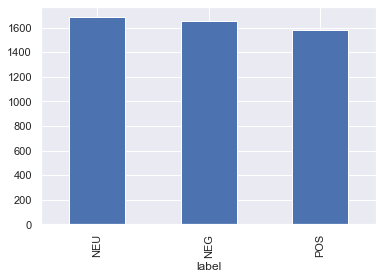

In [21]:
train_df.value_counts('label').plot(kind='bar')

In [22]:
# # save to file
# train_df.to_csv('../data/clean/train.csv', index=False)
# test_df.to_csv('../data/clean/test.csv', index=False)

## Implement Star Space model

In [24]:
word_counts = {}
for text in train_df['text']:
    for word in text.split():
        word_counts[word] = word_counts.get(word, 0) + 1

word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
word_counts_df.sort_values('count', ascending=False, inplace=True)

In [25]:
vocab = set(word_counts_df[word_counts_df['count'] >= 5].index)
len(vocab)

1998

In [26]:
word2idx = {word: idx for idx, word in enumerate(vocab, 1)}
word2idx['<unk>'] = 0
label2idx = {'POS': 0, 'NEG': 1, 'NEU': 2}
len(word2idx)

1999

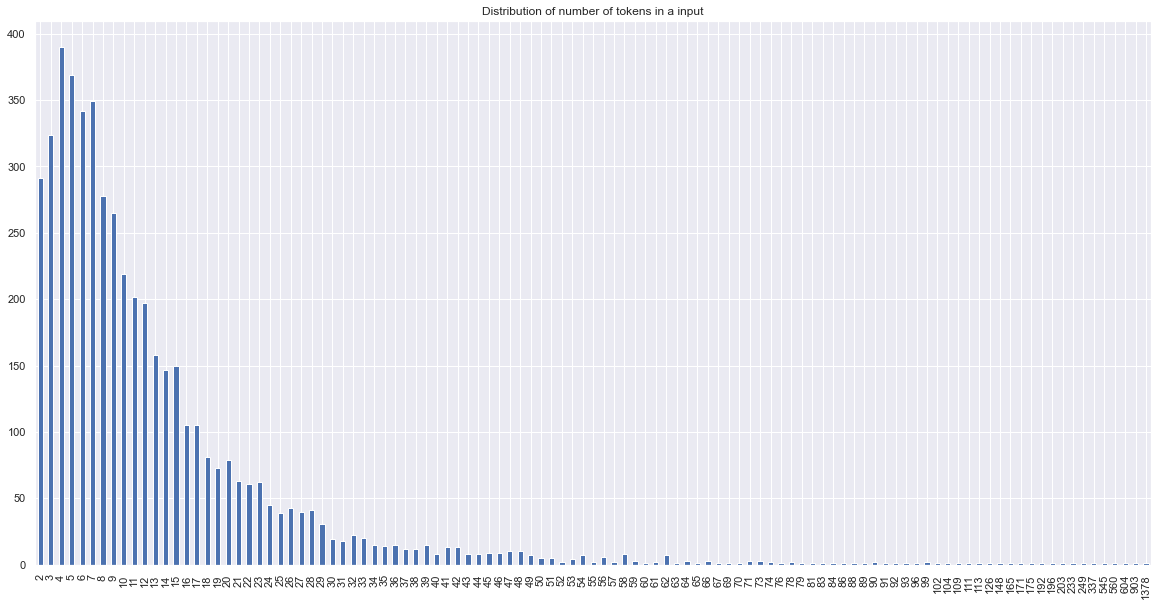

In [28]:
plt.figure(figsize=(20, 10))
len_df = train_df['text'].apply(lambda x: len(x.split()))
plt.title('Distribution of number of tokens in a input')
len_df.value_counts().sort_index().plot(kind='bar')
plt.show()

In [29]:
max_len = train_df['text'].apply(lambda x: len(x.split())).max()

In [30]:
class Dataset(Dataset):
    def __init__(self, df_train, df_test, word2idx, label2idx, cur_set='train', max_len=max_len):
        self.cur_set = cur_set
        self.word2idx = word2idx
        self.max_len = max_len
        self.label2idx = label2idx

        train, val = train_test_split(df_train, test_size=0.2, random_state=42)
        self.lookup = {
            'train': train.reset_index(drop=True).copy(),
            'val': val.reset_index(drop=True).copy(),
            'test': df_test.reset_index(drop=True).copy()
        }
        
    def __len__(self):
        return len(self.lookup[self.cur_set])

    def __getitem__(self, idx):
        text = self.lookup[self.cur_set]['text'][idx]
        text = text[:self.max_len]
        text_idx = [self.word2idx.get(word, self.word2idx['<unk>']) for word in text.split()]
        text_idx = text_idx + [0] * (self.max_len - len(text_idx))

        label = self.lookup[self.cur_set]['label'][idx]
        
        return torch.tensor(text_idx), torch.tensor([self.label2idx[label]])

    def get_dl(self, batch_size=32, shuffle=True, drop_last=True, cur_set='train'):
        self.cur_set = cur_set
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

In [31]:
class MarginRankingLoss(nn.Module):
    def __init__(self, margin=1, reduction=torch.mean):
        super().__init__()
        self.margin = torch.tensor(margin)
        self.reduction = reduction
        
    def forward(self, pos_sim, neg_sim): # pos_sim: (batch_size, 1), neg_sim: (batch_size, n_y)
        loss = torch.clamp(self.margin - pos_sim + neg_sim, min=0)
        return self.reduction(loss)
        
class InnerProductSimilarity(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y): # x: (batch_size, 1, embedding_dim), y: (batch_size, n_y, embedding_dim)
        return torch.bmm(x, y.transpose(1, 2)).squeeze(1) # shape = (batch_size, n_y)

class StarSpaceClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, embedding_dim=32, hidden_size=32, agg=torch.mean):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.label_embeddings = nn.Embedding(num_classes, embedding_dim)
        self.fc1 = nn.Sequential(                 # if use ==> worse performance
        )
        self.fc2 = nn.Sequential(
        )
        self.agg = agg
        
    def forward(self, x, y, label_set = set([0, 1, 2])):
        x = self.word_embeddings(x)
        x_repr = self.fc1(x)
        x_repr = self.agg(x_repr, dim=1)
        x_repr = x_repr.unsqueeze(1)

        y_pos_embed = self.label_embeddings(y)
        y_pos = self.fc2(y_pos_embed)
        y_pos = self.agg(y_pos, dim=1)
        y_pos = y_pos.unsqueeze(1)

        y_neg_label = []
        for i in range(y.shape[0]):
            y_neg_label.append(list(label_set - set([y[i].item()])))
        y_neg_label = torch.tensor(y_neg_label)
        y_neg_embed = self.label_embeddings(y_neg_label)
        y_neg = self.fc2(y_neg_embed)

        return x_repr, y_pos, y_neg
    
    @torch.no_grad()
    def predict(self, x):
        x = self.word_embeddings(x)
        x_repr = self.fc1(x)
        x_repr = self.agg(x_repr, dim=1)
        x_repr = x_repr.unsqueeze(1)

        labels = torch.tensor(list(range(3)))
        # take embedding of all labels
        y_embed = self.label_embeddings(labels)
        y = self.fc2(y_embed)
        sims = torch.bmm(x_repr, y.repeat(x_repr.shape[0], 1, 1).transpose(1, 2)).squeeze(1)
        _, pred = torch.max(sims, dim=1)
        return pred

In [32]:
dataset = Dataset(train_df, test_df, word2idx, label2idx)

In [33]:
model = StarSpaceClassifier(len(word2idx), len(label2idx))
loss = MarginRankingLoss()
sim = InnerProductSimilarity()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [34]:
def train(model, dataset, loss, sim, optimizer, epochs=10):
    for epoch in range(epochs):
        losses, accs = [], []
        model.train()
        train_dl = dataset.get_dl(cur_set='train')
        for batch in tqdm(train_dl):
            x, y = batch
            x_repr, y_pos, y_neg = model(x, y)
            pos_sim = sim(x_repr, y_pos)
            neg_sim = sim(x_repr, y_neg)
            loss_val = loss(pos_sim, neg_sim)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            losses.append(loss_val.item())
            y_pred = model.predict(x)
            acc = (y_pred == y.squeeze(1)).sum().item() / y.shape[0]
            accs.append(acc)

        val_dl = dataset.get_dl(cur_set='val')
        val_losses, val_accs = [], []
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dl):
                x, y = batch
                x_repr, y_pos, y_neg = model(x, y)
                pos_sim = sim(x_repr, y_pos)
                neg_sim = sim(x_repr, y_neg)
                loss_val = loss(pos_sim, neg_sim)
                val_losses.append(loss_val.item())
                y_pred = model.predict(x)
                acc = (y_pred == y.squeeze(1)).sum().item() / y.shape[0]
                val_accs.append(acc)
            
        print(f'Epoch {epoch+1}/{epochs}, train loss: {np.mean(losses):.4f}, train acc: {np.mean(accs):.4f}, val loss: {np.mean(val_losses):.4f}, val acc: {np.mean(val_accs):.4f}')

def test(model, dataset, loss, sim):
    # evaluate on test set
    test_dl = dataset.get_dl(cur_set='test')
    test_losses, test_accs = [], []
    model.eval()
    y_trues, y_preds = [], []
    with torch.no_grad():
        for batch in tqdm(test_dl):
            x, y = batch
            x_repr, y_pos, y_neg = model(x, y)
            pos_sim = sim(x_repr, y_pos)
            neg_sim = sim(x_repr, y_neg)
            loss_val = loss(pos_sim, neg_sim)
            test_losses.append(loss_val.item())
            y_pred = model.predict(x)
            acc = (y_pred == y.squeeze(1)).sum().item() / y.shape[0]
            test_accs.append(acc)
            y_trues.extend(y.squeeze(1).tolist())
            y_preds.extend(y_pred.tolist())

    print(classification_report(y_trues, y_preds))
    # plot confusion matrix
    cm = confusion_matrix(y_trues, y_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [38]:
train(model, dataset, loss, sim, optimizer, epochs=10)

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/10, train loss: 0.5563, train acc: 0.7303, val loss: 0.7023, val acc: 0.6052


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/10, train loss: 0.5483, train acc: 0.7326, val loss: 0.7008, val acc: 0.6021


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/10, train loss: 0.5405, train acc: 0.7344, val loss: 0.6959, val acc: 0.6042


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/10, train loss: 0.5324, train acc: 0.7377, val loss: 0.6911, val acc: 0.6021


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/10, train loss: 0.5246, train acc: 0.7428, val loss: 0.6905, val acc: 0.5969


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/10, train loss: 0.5176, train acc: 0.7449, val loss: 0.6899, val acc: 0.5969


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/10, train loss: 0.5114, train acc: 0.7454, val loss: 0.6836, val acc: 0.6010


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8/10, train loss: 0.5063, train acc: 0.7480, val loss: 0.6816, val acc: 0.5979


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/10, train loss: 0.5000, train acc: 0.7492, val loss: 0.6789, val acc: 0.6031


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/10, train loss: 0.4931, train acc: 0.7523, val loss: 0.6760, val acc: 0.6021


  0%|          | 0/31 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.65      0.64      0.65       325
           1       0.67      0.61      0.64       329
           2       0.58      0.64      0.61       338

    accuracy                           0.63       992
   macro avg       0.63      0.63      0.63       992
weighted avg       0.63      0.63      0.63       992



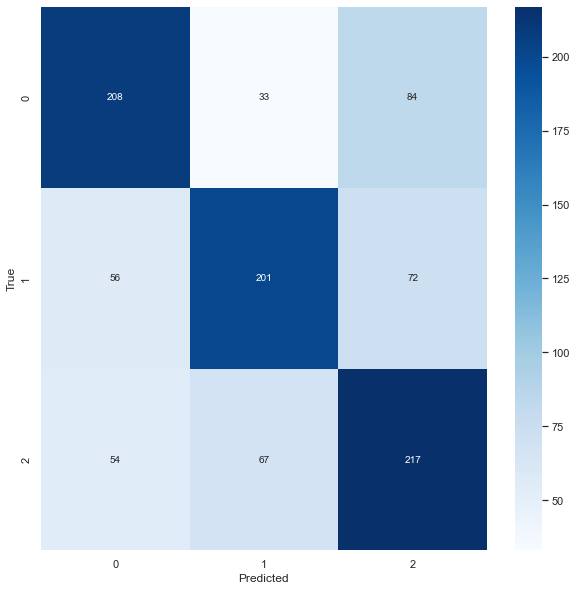

In [39]:
test(model, dataset, loss, sim)

In [40]:
# save model
# torch.save(model.state_dict(), '../models/starspace.pt')

In [ ]:
m = torch.bmm(a, b.transpose(1, 2)).squeeze(1)
n = torch.bmm(a, c.transpose(1, 2)).squeeze(1)
torch.mean(torch.clamp(1 - m + n, min=0))


tensor(1.0768, grad_fn=<MeanBackward0>)

In [ ]:
sim = InnerProductSimilarity()
pos_sim = sim(a, b)

In [ ]:
torch.mean(torch.tensor([
    [1, 2, 3],
    [4, 5, 6]
], dtype=torch.float))

tensor(3.5000)

In [ ]:
pos_sim.shape

torch.Size([32, 1])

In [ ]:
a = torch.tensor([1,2,3])
a.repeat(2, 1)

tensor([[1, 2, 3],
        [1, 2, 3]])